In [1]:
import scipy as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import time
import h5py as h5
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

%matplotlib inline

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) =\mathcal{L}(r, \alpha, R) = \frac{4\pi}{(2\pi)^3}\int_0^\infty \frac{q\sin{qr}}{r}e^{-|qR|^\alpha}dq
\end{equation}

\begin{equation}
\int_a^b f(x)dx = \frac{b-a}{2}\int_{-1}^1 f\bigg(\frac{b-a}{2}z+\frac{a+b}{2}\bigg)dz = \sum_i w_i f(x_i)
\end{equation}

\begin{equation}
    \int_{z}^{z+\Delta z} f(x)dx = \frac{\Delta z}{2}\int_{-1}^1 f\bigg(\frac{\Delta z}{2}\xi+\frac{2z+\Delta z}{2}\bigg)d\xi = \sum_i w_i f(\xi_i)
\end{equation}

0.0013766304573


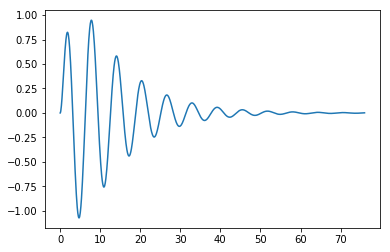

In [2]:
alpha=0.7
mm = np.power(-np.log(1e-9), 1/alpha)
x = np.linspace(0, mm, 1000)
y = x*np.sin(x*1)*np.exp(-np.power(x, alpha)/2)
print(y[-1]/max(y))
plt.plot(x,y)

In [3]:
mod = SourceModule("""
#include <nvfunctional>
#include <float.h>
#include <nppdefs.h>

#define M_PI acos(-1.0)

template <class T=float, int N=8, int halfN=N/2> class KGInt{
  T weights[N], nodes[N];
  T targetError, estimatedError;
  T integralKronrod, integralGauss, absIntegral, absDiffIntegral;
  T f1[N], f2[N];
  T fValue1, fValue2;
  T center, halfLength, mean;
  T _min;
  T _eps;
  int i,idx;
  nvstd::function<void(const T&, T&)> func;
  
  __device__ void integrateOneStep();
  
public:
  __device__ KGInt():
    nodes{
          0.99145537112081263920685469752632851664204433837033,
          0.94910791234275852452618968404785126240077093767062,
          0.86486442335976907278971278864092620121097230707409,
          0.74153118559939443986386477328078840707414764714139,
          0.58608723546769113029414483825872959843678075060436,
          0.40584515137739716690660641207696146334738201409937,
          0.20778495500789846760068940377324491347978440714517,
          0.00000000000000000000000000000000000000000000000000
      },
      weights{
          0.02293532201052922496373200805896959199356081127575,
          0.06309209262997855329070066318920428666507115721155,
          0.10479001032225018383987632254151801744375665421383,
          0.14065325971552591874518959051023792039988975724800,
          0.16900472663926790282658342659855028410624490030294,
          0.19035057806478540991325640242101368282607807545536,
          0.20443294007529889241416199923464908471651760418072,
          0.20948214108472782801299917489171426369776208022370
    }{
    // Gauss-nodes: 1, 3, 5, 7
    _eps = FLT_EPSILON*50.;
    _min = NPP_MINABS_32F/_eps;
  }
  
   __device__ double integrate(const nvstd::function<void(const T&, T&)>&, const T&, const T&, const T&);
};

template<class T, int N, int halfN> __device__ void KGInt<T, N, halfN>::integrateOneStep(){
    integralGauss   = .0;
    absIntegral     = .0;
    for(i=0;i<(halfN-1);i++){
      idx = 2*i+1;
      func(center+nodes[idx]*halfLength, fValue1);
      func(center-nodes[idx]*halfLength, fValue2);
      integralGauss += weights[idx]*(fValue1+fValue2);
      absIntegral   += weights[idx]*(abs(fValue1)+abs(fValue2));
      f1[idx] = fValue1;
      f2[idx] = fValue2;
    }
    func(center, fValue1);
    integralGauss += weights[N-1]*fValue1;
    absIntegral   += weights[N-1]*abs(fValue1);
    f1[N-1] = fValue1;
    
    integralKronrod = integralGauss;
    for(i=0;i<halfN;i++){
      idx = 2*i;
      func(center+nodes[idx]*halfLength, fValue1);
      func(center-nodes[idx]*halfLength, fValue2);
      integralKronrod += weights[idx]*(fValue1+fValue2);
      absIntegral     += weights[idx]*(abs(fValue1)+abs(fValue2));
      f1[idx] = fValue1;
      f2[idx] = fValue2;
    }
    
    mean = integralKronrod/2.;
    absDiffIntegral = weights[N-1]*abs(f1[N-1]-mean);
    for(i=0;i<(N-1);i++){
      absDiffIntegral += weights[i]*(abs(f1[i]-mean)+abs(f2[i]-mean));
    }
    
    absIntegral *= halfLength;
    absDiffIntegral *= halfLength;
    
    estimatedError = abs(integralKronrod-integralGauss)*halfLength;
    
    integralKronrod *= halfLength;
    
    if (absDiffIntegral!=0. && estimatedError!= 0.){
      estimatedError = absDiffIntegral*min(1.,pow(estimatedError*200./absDiffIntegral,1.5));
    }
    
    if (absIntegral>_min){
      estimatedError = max(estimatedError, absIntegral*_eps);
    }
}


template<class T,int N, int halfN> __device__ double KGInt<T,N, halfN>::integrate(const nvstd::function<void(const T&, T&)>& f, const T& a, const T& b, const T& error)
{  
  func = f;
  targetError = error;
  double z = a;
  double dz = 1e-8;
  double integral = 0.0;
  int j=0;
  while(z<b){
    for(j=0;j<1000;j++){
      center     = z+0.5*dz;
      halfLength = 0.5*dz;
      integrateOneStep();
      if (estimatedError<=targetError) break;
      dz *=targetError/estimatedError;
    }
    integral += integralKronrod;
    z += dz;
    if (estimatedError<targetError){
      dz *= 2;
    }
  }
  return integral;
}



extern "C" {
  __global__ void integrate(double * res, float * rs, float * alphas, float * errors, float * errors_rng){
      int idx = blockDim.x*blockIdx.x+threadIdx.x;
      KGInt<float> imod;
      res[idx] = imod.integrate([&alpha=alphas[idx], &r=rs[idx]](const float& x, float& y)->void{
         y = x*sinf(x*r)*expf(-powf(x, alpha));
      }, .0, powf(-logf(errors_rng[idx]),1/alphas[idx]), errors[idx]);
      res[idx] /= 2*M_PI*M_PI*rs[idx];
  }
}
""", no_extern_c=True,options=["--ptxas-options=-v"])

In [4]:
cuda_int = mod.get_function("integrate")

In [5]:
threadN = 1
blockN  = 1
N = threadN*blockN
res = np.array([0.0]*N, dtype=np.float64)
rs  = np.array([10.0]*N, dtype=np.float32)
alphas = np.array([0.8]*N, dtype=np.float32)
errors = np.array([1e-7]*N, dtype=np.float32)
errors_rng = np.array([1e-8]*N, dtype=np.float32)

In [6]:
cuda_int(cuda.Out(res), cuda.In(rs), cuda.In(alphas), cuda.In(errors), cuda.In(errors_rng),
          block=(threadN,1,1), grid=(blockN,1), time_kernel=True)

1.3323707580566406

In [7]:
res[0]

1.1252325043417356e-05

In [8]:
integrate.quad(lambda x: x*np.sin(rs[0]*x)*np.exp(-np.power(x, alphas[0])), 0,np.inf, limit=1000)[0]/(2*rs[0]*np.pi**2)

1.1252382920334281e-05

In [9]:
from KGInt import integrate as kgint

In [10]:
N=4
rs=np.array([rs[0]]*N, np.float64)
alphas=np.array([alphas[0]]*N, np.float64)
errors =np.array([1e-8]*N, np.float64)
error_rngs=np.array([1e-9]*N, np.float64)
kgint(rs,alphas, errors, error_rngs)

Elapsed time: 118.0 ms


array([[  1.12524014e-05,   2.99356413e-11],
       [  1.12524014e-05,   2.99356413e-11],
       [  1.12524014e-05,   2.99356413e-11],
       [  1.12524014e-05,   2.99356413e-11]])